In [1]:
import xarray as xr
import glob
MODELINFO=[["ACCESS-ESM1-5",101,249],\
           ["CanESM5",1850,2000],\
           ["CESM2",1,150],\
           ["EC-Earth3-CC",1850,2000],\
           ["FGOALS-g3",370,525],\
           ["MIROC6",3200,3349],\
           ["MRI-ESM2-0",1850,2000],\
           ["NorESM2-LM",1,150],\
           ["NorESM2-MM",1,150],\
           ["GFDL-ESM4",1,150],\
           ["CanESM5-1",101,249],\
           ["CAS-ESM2-0",1850,2000],\
           ["CESM2-WACCM",1850,2000],\
           ["CESM2-WACCM-FV2",370,525],\
           ["E3SM-1-0",3200,3349],\
           ["E3SM-2-0",1850,2000],\
           ["E3SM-2-0-NARRM",1850,2000],\
           ["FGOALS-f3-L",1,150],\
           ["GISS-E2-1-G",1,150],\
           ["AWI-CM-1-1-MR",1850,2000]]

GRIDINFO=[["/pr_day_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_01510101-02001231.nc"],\
          ["/pr_day_CanESM5_1pctCO2_r1i1p1f1_gn_18500101-20001231.nc"],\
          ["/pr_day_CESM2_1pctCO2_r1i1p1f1_gn_00710101-00801231.nc"],\
          ["/pr_day_EC-Earth3-CC_1pctCO2_r1i1p1f1_gr_19080101-19081231.nc"],\
          ["/pr_day_FGOALS-g3_1pctCO2_r1i1p1f1_gn_05160101-05161231.nc"],\
          ["/pr_day_MIROC6_1pctCO2_r1i1p1f1_gn_32800101-32891231.nc"],\
          ["/pr_day_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_18500101-18991231.nc"],\
          ["/pr_day_NorESM2-LM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"],\
          ["/pr_day_NorESM2-MM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"]]

MASKINFO=[["/pr_day_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_01510101-02001231.nc"],\
          ["/pr_day_CanESM5_1pctCO2_r1i1p1f1_gn_18500101-20001231.nc"],\
          ["/pr_day_CESM2_1pctCO2_r1i1p1f1_gn_00710101-00801231.nc"],\
          ["/pr_day_EC-Earth3-CC_1pctCO2_r1i1p1f1_gr_19080101-19081231.nc"],\
          ["/pr_day_FGOALS-g3_1pctCO2_r1i1p1f1_gn_05160101-05161231.nc"],\
          ["/pr_day_MIROC6_1pctCO2_r1i1p1f1_gn_32800101-32891231.nc"],\
          ["/pr_day_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_18500101-18991231.nc"],\
          ["/pr_day_NorESM2-LM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"],\
          ["/pr_day_NorESM2-MM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"],\
          ["/pr_day_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_00610101-00801231.nc"],\
          ["/pr_day_GFDL-CM4_1pctCO2_r1i1p1f1_gr1_00210101-00401231.nc"]]
model_names = [model[0] for model in MODELINFO]
model_start = [model[1] for model in MODELINFO]
model_end = [model[2] for model in MODELINFO]
GRID = [model[0] for model in GRIDINFO]
MASK = [model[0] for model in MASKINFO]
lenyear=100
miss_val = -9.99e08
model_names

['ACCESS-ESM1-5',
 'CanESM5',
 'CESM2',
 'EC-Earth3-CC',
 'FGOALS-g3',
 'MIROC6',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'GFDL-ESM4',
 'CanESM5-1',
 'CAS-ESM2-0',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'E3SM-1-0',
 'E3SM-2-0',
 'E3SM-2-0-NARRM',
 'FGOALS-f3-L',
 'GISS-E2-1-G',
 'AWI-CM-1-1-MR']

In [2]:
from scipy import optimize
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import xarray as xr
import sys
import scipy.io
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os.path
from os import path
import netCDF4
from statsmodels.tsa.stattools import acf
import netCDF4 as nc
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
from copy import copy
from scipy.stats import pearsonr
def weighted_percentile(cli_pr, weights, percentile):
    # Flatten the 2D arrays and remove NaN values
    flat_array = cli_pr.flatten()
    valid_indices = np.logical_not(np.isnan(flat_array))
    sorted_indices = np.argsort(flat_array[valid_indices])
    sorted_array = flat_array[valid_indices][sorted_indices]
    sorted_weights = weights.flatten()[valid_indices][sorted_indices]
    
    # Calculate the cumulative sum of the sorted weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    
    # Find the index corresponding to the desired percentile
    target_index = np.searchsorted(cumulative_weights, total_weight * (percentile / 100.0))
    
    # Get the value at the target index in the sorted array
    percentile_value = sorted_array[target_index]
    
    return percentile_value


def giniw(x, w=None):
# from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
    # The rest of the code requires numpy arrays.
#     x = np.asarray(x)
    if w is not None:
#         w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
#         x = np.asarray(x)
        sorted_x = np.sort(x)
        n = x.size
        cumx = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

    
def find_weighted_percentile_rank(cli_pr, weights, value):
    flat_array = cli_pr.flatten()
    flat_weights = weights.flatten()
    
    # Sort the values and corresponding weights
    sorted_indices = np.argsort(flat_array)
    sorted_array = flat_array[sorted_indices]
    sorted_weights = flat_weights[sorted_indices]
    
    # Calculate the cumulative sum of the sorted weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    
    # Find the index of the value in the sorted array
    index = np.searchsorted(sorted_array, value)
    
    # Calculate the percentile rank considering weight
    percentile_rank = (cumulative_weights[index] / total_weight) * 100
    
    return percentile_rank

def calculate_mann_kendall(x):
    n = len(x)
    s = 0
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(x[j] - x[k])
    trend = s / (n * (n - 1) / 2)
    var_s = (n * (n - 1) * (2 * n + 5)) / 18
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    p = 2 * (1 - norm.cdf(abs(z)))
    return trend, p

def spa_lag(X, k):

    tree = cKDTree(X)
    spatial_lag = []

    for point in X:
        # Query the k nearest neighbors' indices
        _, indices = tree.query(point, k=k+1)  # +1 to exclude the point itself

        # Calculate the spatial lag by averaging the values of the k nearest neighbors
        spatial_lag_value = np.mean(X[indices[1:], :], axis=0)  # Exclude the first index which is the point itself
        spatial_lag.append(spatial_lag_value)

    spatial_lag = np.array(spatial_lag)
    return spatial_lag



MODELINFO=[["ACCESS-ESM1-5",101,249],\
           ["CanESM5",1850,2000],\
           ["CESM2",1,150],\
           ["EC-Earth3-CC",1850,2000],\
           ["FGOALS-g3",370,525],\
           ["MIROC6",3200,3349],\
           ["MRI-ESM2-0",1850,2000],\
           ["NorESM2-LM",1,150],\
           ["NorESM2-MM",1,150],\
           ["GFDL-ESM4",1,150],\
           ["CanESM5-1",101,249],\
           ["CAS-ESM2-0",1850,2000],\
           ["CESM2-WACCM",1850,2000],\
           ["CESM2-WACCM-FV2",370,525],\
           ["E3SM-1-0",3200,3349],\
           ["E3SM-2-0",1850,2000],\
           ["E3SM-2-0-NARRM",1850,2000],\
           ["FGOALS-f3-L",1,150],\
           ["GISS-E2-1-G",1,150],\
           ["AWI-CM-1-1-MR",1850,2000]]

model_names = [model[0] for model in MODELINFO]
model_start = [model[1] for model in MODELINFO]
model_end = [model[2] for model in MODELINFO]
model_names

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
projection = ccrs.PlateCarree()

In [3]:
from sklearn.linear_model import LinearRegression
P_regridded2 = np.full((10, 90, 180), np.nan)
SM_regridded2 = np.full((10, 90, 180), np.nan)
G_regridded2 = np.full((10, 90, 180), np.nan)
SMB_regridded2 = np.full((10, 90, 180), np.nan)
PB_regridded2 = np.full((10, 90, 180), np.nan)
GB_regridded2 = np.full((10, 90, 180), np.nan)
DB_regridded2 = np.full((10, 90, 180), np.nan)
D_regridded2 = np.full((10, 90, 180), np.nan)

for model in range(10):
    data3 = xr.open_dataset('/scratch/cimes/hh9736/CMIP6_pr/' + model_names[model] + MASK[model])
    D_trend = np.load('/scratch/cimes/hh9736/CMIP6_pr/Temporal_inequality/Trend_NofDDAY_' + model_names[model] + '.npy')
    D_BaseState = np.load('/scratch/cimes/hh9736/CMIP6_pr/Temporal_inequality/BaseState_NofDDAY_' + model_names[model] + '.npy')
    G_trend = np.load('/scratch/cimes/hh9736/CMIP6_pr/Temporal_inequality/Trend_GINI_' + model_names[model] + '.npy')
    P_trend = np.load('/scratch/cimes/hh9736/CMIP6_pr/Analysis/Trend_P_' + model_names[model] + '.npy')
    SM_trend = np.load('/scratch/cimes/hh9736/CMIP6_pr/Analysis/Trend_SM_' + model_names[model] + '.npy')

    #GINI_BaseState = np.load('/scratch/cimes/hh9736/CMIP6_pr/Temporal_inequality/BaseState_GINI_' + model_names[model] + '.npy')
    P_BaseState = np.load('/scratch/cimes/hh9736/CMIP6_pr/Analysis/BaseState_P_' + model_names[model] + '.npy')
    SM_BaseState = np.load('/scratch/cimes/hh9736/CMIP6_pr/Analysis/BaseState_SM_' + model_names[model] + '.npy')
    G_BaseState = np.load('/scratch/cimes/hh9736/CMIP6_pr/Temporal_inequality/BaseState_GINI_' + model_names[model] + '.npy')
    
    filename = f'/scratch/cimes/hh9736/CMIP6_pr/Analysis/Spatial_mean_T_ts_' + model_names[model] + '.npy'
    arrT = np.load(filename)
    arrT = arrT[0,:]-arrT[0,0]
    years = np.arange(1, 101).reshape(-1, 1)
    SM_trend[SM_trend==0]=np.nan
    P_trend[P_trend>1000]=np.nan
    P_trend[P_trend<-1000]=np.nan
    SM_trend[0,0:round(SM_trend.shape[1]/6),:]=np.nan
    SM_trend[0,round(5*SM_trend.shape[1]/6):SM_trend.shape[1],:]=np.nan    
    
    # Reshape arrT to a column vector
    arrT_reshaped = arrT.reshape(-1, 1)

    # Create a linear regression model
    model1 = LinearRegression()

    # Fit the model to your data
    model1.fit(years, arrT_reshaped)

    # Get the slope (trend) and intercept of the fitted line
    T_trend = model1.coef_[0][0]
    
    
    lats = data3['lat'].values
    lons = data3['lon'].values-180
    lon_new = np.linspace(-180, 180, 180)
    lat_new = np.linspace(-90, 90, 90)
    # Assuming P is your original 2D numpy array
    # Define the original latitudes and longitudes (lon and lat should be 1D arrays)
    lat_original = lats  # Replace with your original longitudes
    lon_original = lons  # Replace with your original latitudes
    new_grid = xr.Dataset({'lon': (['lon'], lon_new), 'lat': (['lat'], lat_new)})

    data_array = xr.DataArray(P_trend[0,:,:]/T_trend, coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    P_regridded2[model] = regridded_data.values
    
    data_array = xr.DataArray(SM_trend[0,:,:]/T_trend, coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    SM_regridded2[model] = regridded_data.values
    
    data_array = xr.DataArray(G_trend[0,:,:]/T_trend, coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    G_regridded2[model] = regridded_data.values
    
    data_array = xr.DataArray(SM_BaseState[0,:,:], coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    SMB_regridded2[model] = regridded_data.values    
    
    data_array = xr.DataArray(P_BaseState[0,:,:], coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    PB_regridded2[model] = regridded_data.values    

    data_array = xr.DataArray(G_BaseState[0,:,:], coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    GB_regridded2[model] = regridded_data.values    

    data_array = xr.DataArray(D_BaseState[0,:,:], coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    DB_regridded2[model] = regridded_data.values    

    data_array = xr.DataArray(D_trend[0,:,:]/T_trend, coords=[('lat', lat_original), ('lon', lon_original)])
    regridded_data = data_array.interp(lon=new_grid['lon'], lat=new_grid['lat'], method='linear')
    D_regridded2[model] = regridded_data.values        

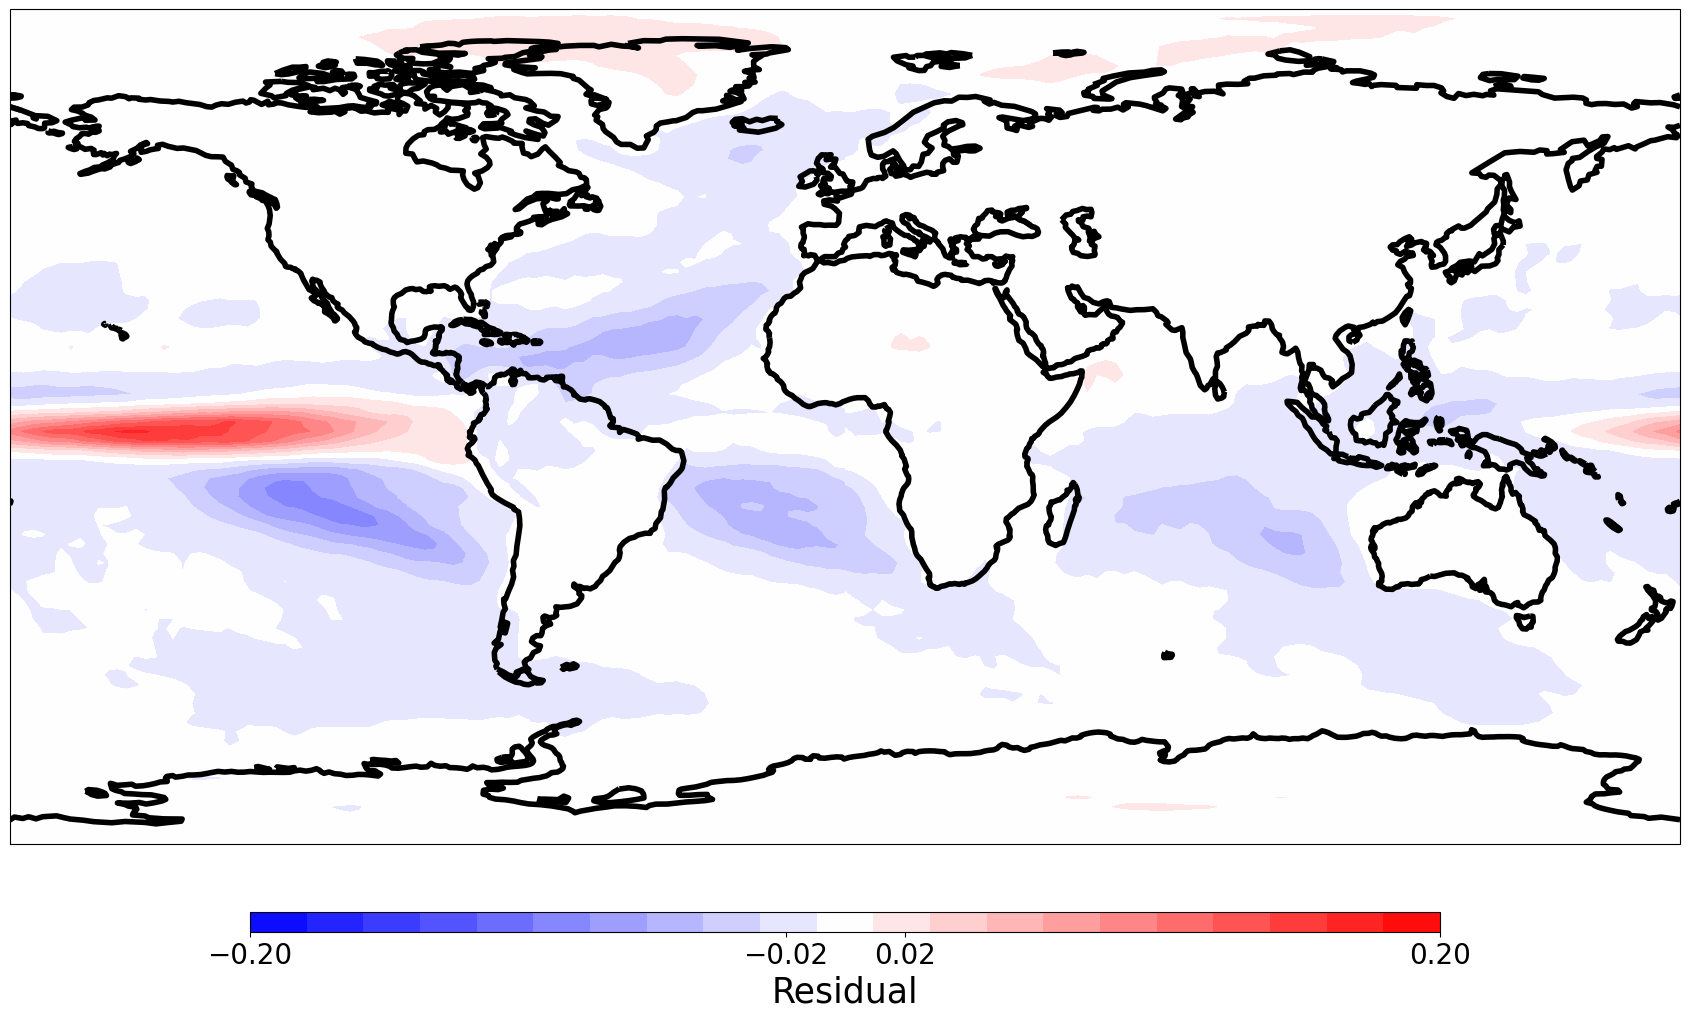

In [4]:


projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(17, 10), subplot_kw=dict(projection=projection))
dP = np.nanmean(P_regridded2, axis=0)
dSM = np.nanmean(SM_regridded2, axis=0)
dG = np.nanmean(G_regridded2, axis=0)
dD = np.nanmean(D_regridded2, axis=0)
Gb = np.nanmean(GB_regridded2, axis=0)
Db = np.nanmean(DB_regridded2, axis=0)
Pb = np.nanmean(PB_regridded2, axis=0)

lenlat = dP.shape[0]
lenlon = dP.shape[1]    
lon = np.linspace(0, 360, lenlon)
lat = np.linspace(-90, 90, lenlat)
lon, lat = np.meshgrid(lon, lat)  
predictor = (Gb-1)*(365-Db)/365*((Pb+dP)/Pb/1.07-1)
rr2=-1*(predictor-dG)
upp=0.2
boo=-0.2
rr2[rr2>upp]=upp
rr2[rr2<boo]=boo
rr2[:,179]=(rr2[:,0]+rr2[:,178])/2

levels = np.linspace(boo, upp, 22) 

im=plt.contourf(lon, lat, rr2,levels=levels,cmap='bwr', origin='lower', transform=projection , extent=[-180, 180, -90, 90])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=4)  # You can adjust linewidth and edgecolor as desired


#plt.savefig("scatter_D_dG_dD_indivudualmodel_land.png", format="png", bbox_inches="tight")   
plt.tight_layout(rect=[0, 0.07, 1, 1])  # Adjust the subplot layout to accommodate the colorbar
cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])  # Specify colorbar position and size
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=[boo,boo/10, upp/10,upp])
cbar.set_label('Residual', fontsize=25) 
cbar.ax.tick_params(labelsize=20)
plt.savefig("Residual_of_prediction.png", format="png", bbox_inches="tight")   

#Set ticks for the colorbar

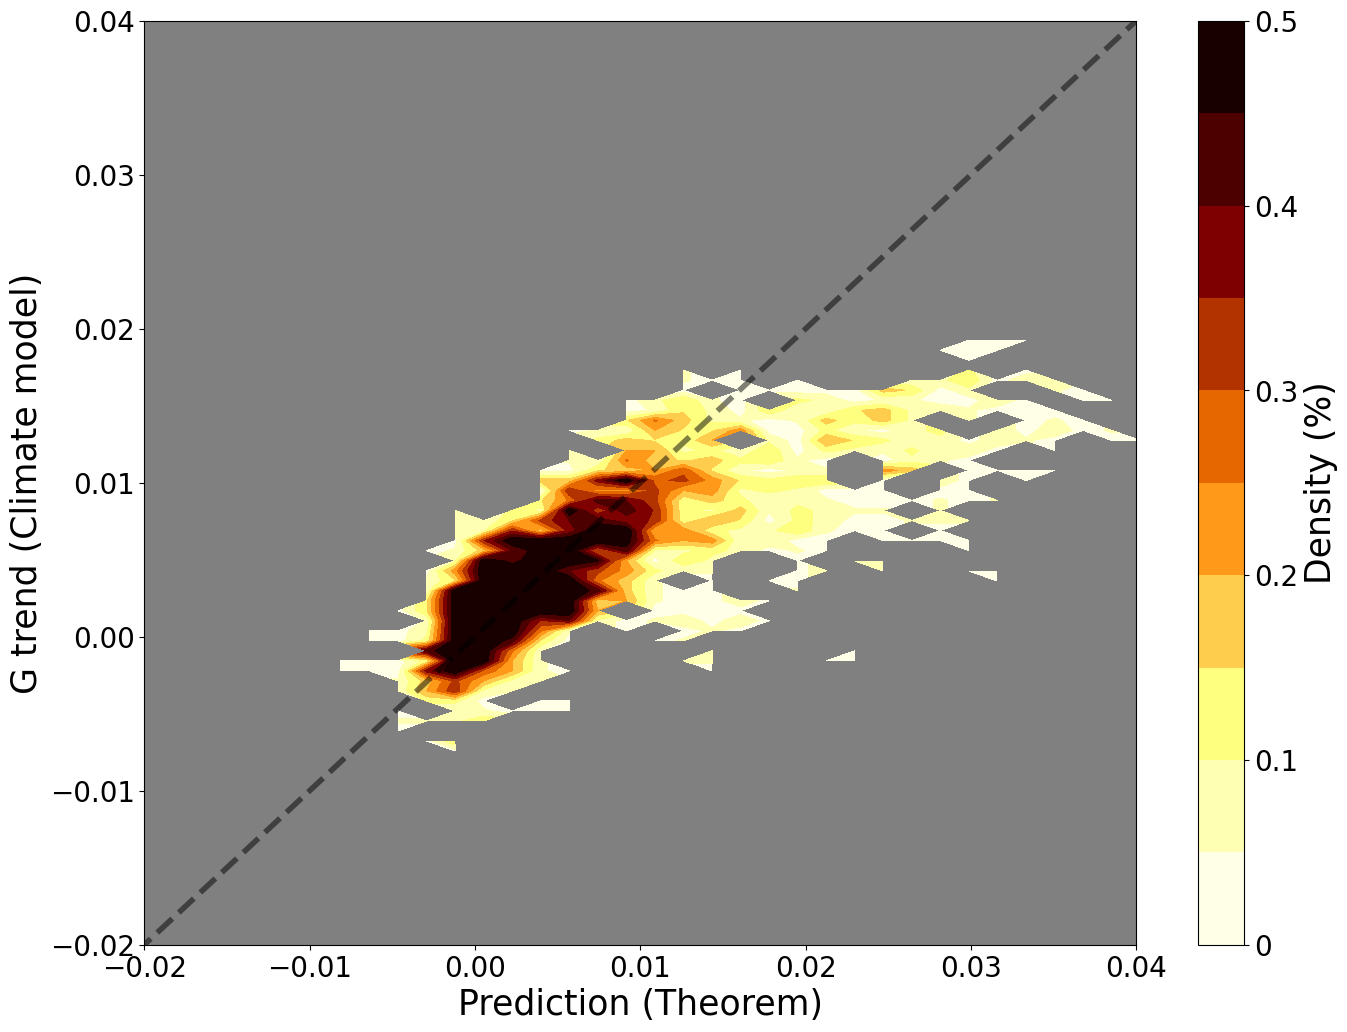

In [16]:
#land only

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(16,12))
# Your data cleaning code remains the same
mask = ~np.isnan(predictor) & ~np.isnan(dG) & ~np.isnan(dSM)

latitude = np.linspace(-90, 90, dG.shape[0])

#predictor[predictor>0.05]=0.051
#predictor[predictor<-0.05]=-0.051
##dG[dG>0.05]=0.051
#dG[dG<-0.05]=-0.051
weight_matrix = np.outer(np.cos(np.radians(latitude)), np.ones(dP.shape[1]))

weight_matrix = weight_matrix[mask]
W = weight_matrix

predictor_cleaned = predictor[mask]
dG_cleaned = dG[mask]
# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(predictor_cleaned.flatten(), dG_cleaned.flatten(), bins=(50, 50), density=False)
# Convert the density values to log scale
hist=hist/np.nansum(hist)*100
vmin, vmax = 0,.5 # Adjust the range according to your data
hist[hist>vmax]=vmax
hist[hist==0]=np.nan
#hist[np.isnan(hist)]=0
levels = np.linspace(0, .5, 11)
# Create a density scatter plot using pcolormesh with specified color scale range
#plt.pcolormesh(xedges, yedges, hist.T, cmap='afmhot_r', vmin=vmin, vmax=vmax)
plt.contourf(xedges[0:50], yedges[0:50], hist.T,levels=levels, cmap='afmhot_r')
# Create a density scatter plot using pcolormesh
plt.axis(ymin=-.02, ymax=.04)
plt.axis(xmin=-.02, xmax=.04)    
# Add colorbar
cbar = plt.colorbar(label='Density (%)')
cbar.ax.set_ylabel('Density (%)', fontsize=25)

# Set colorbar ticks to represent 0, 10, 100, and 1000 in log scale
cbar.set_ticks(([0,0.1,0.2,0.3,0.4,.5]))
cbar.set_ticklabels([0,0.1,0.2,0.3,0.4,.5])
cbar.ax.tick_params(labelsize=20)
plt.tick_params(labelsize=20)
plt.plot([-.2, .2], [-.2, .2], linestyle='--', color='k', label='1:1 line', linewidth=4, alpha=0.5)
#plt.plot([-.205, .2], [-.2, .205], linestyle='--', color='indianred', label='1:1 line', linewidth=4, alpha=0.5)
#plt.plot([-.2, .205], [-.205, .2], linestyle='--', color='cornflowerblue', label='1:1 line', linewidth=4, alpha=0.5)
your_colormap = plt.cm.afmhot_r  # Replace with your actual colormap

# Extract the color of the first color in the colormap
ax.patch.set_facecolor('grey')
# Set labels and title
plt.xlabel('Prediction (Theorem)',fontsize=25)
plt.ylabel('G trend (Climate model)',fontsize=25)
# Show the plot
plt.savefig("Residual_scatter_streching_land.png", format="png", bbox_inches="tight")   
plt.show()


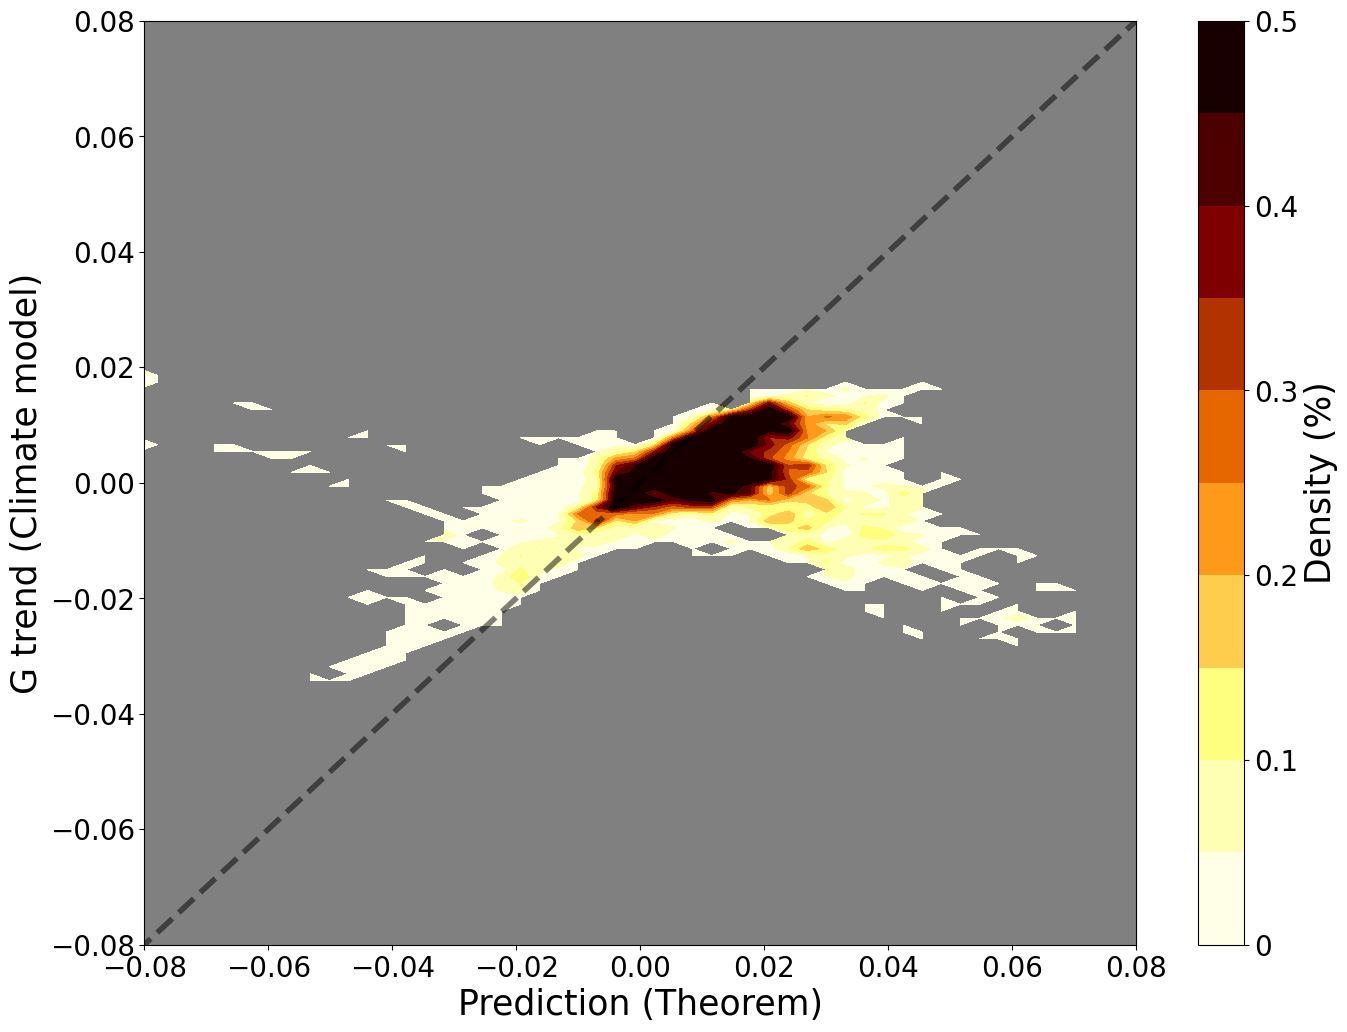

In [17]:
#OCEAN ONLY
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(16,12))
# Your data cleaning code remains the same
mask = ~np.isnan(predictor) & ~np.isnan(dG) & np.isnan(dSM)
latitude = np.linspace(-90, 90, dG.shape[0])

weight_matrix = np.outer(np.cos(np.radians(latitude)), np.ones(dP.shape[1]))

weight_matrix = weight_matrix[mask]
W = weight_matrix

# Create a 2D histogram
predictor_cleaned = predictor[mask]
dG_cleaned = dG[mask]
# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(predictor_cleaned.flatten(), dG_cleaned.flatten(), bins=(50, 50), density=True,weights=W.flatten())
# Convert the density values to log scale
hist=hist/np.nansum(hist)*100
vmin, vmax = 0,.5 # Adjust the range according to your data
hist[hist>vmax]=vmax
hist[hist==0]=np.nan
#hist[np.isnan(hist)]=0
levels = np.linspace(0, .5, 11)
# Create a density scatter plot using pcolormesh with specified color scale range
#plt.pcolormesh(xedges, yedges, hist.T, cmap='afmhot_r', vmin=vmin, vmax=vmax)

plt.contourf(xedges[0:50], yedges[0:50], hist.T,levels=levels, cmap='afmhot_r')
# Create a density scatter plot using pcolormesh
plt.axis(ymin=-.08, ymax=.08)
plt.axis(xmin=-.08, xmax=.08)    
# Add colorbar
cbar = plt.colorbar(label='Density (Interval: 0.001)')
cbar.ax.set_ylabel('Density (%)', fontsize=25)

# Set colorbar ticks to represent 0, 10, 100, and 1000 in log scale
cbar.set_ticks(([0,0.1,0.2,0.3,0.4,.5]))
cbar.set_ticklabels([0,0.1,0.2,0.3,0.4,.5])
cbar.ax.tick_params(labelsize=20)
plt.tick_params(labelsize=20)
plt.plot([-.2, .2], [-.2, .2], linestyle='--', color='k', label='1:1 line', linewidth=4, alpha=0.5)
#plt.plot([-.205, .2], [-.2, .205], linestyle='--', color='indianred', label='1:1 line', linewidth=4, alpha=0.5)
#plt.plot([-.2, .205], [-.205, .2], linestyle='--', color='cornflowerblue', label='1:1 line', linewidth=4, alpha=0.5)
your_colormap = plt.cm.afmhot_r  # Replace with your actual colormap

# Extract the color of the first color in the colormap
ax.patch.set_facecolor('grey')
# Set labels and title
plt.xlabel('Prediction (Theorem)',fontsize=25)
plt.ylabel('G trend (Climate model)',fontsize=25)
# Show the plot
plt.savefig("Residual_scatter_streching_ocean.png", format="png", bbox_inches="tight")   
plt.show()
